# 正态性检验和蒙特卡洛完成投资组合优化

**by 陈小米。**

---

最近一直在思考怎样有效的配置资产组合。
很多时候根据条件选好股票池之后，通常简单粗暴的等分仓位给每只股票。
其实，这个过程中有很多可以优化的空间。

下面，给大家分享一下如何运用**有效前沿**进行资产组合优化。

## PART ONE: 正态性检验
这部分是附赠福利。只对资产组合优化感兴趣的朋友可以直接跳到**PART TWO**。

### **1.导入模块**

In [22]:
%config InlineBackend.figure_format = 'svg'
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import os
path = r'./data/'

colors = plt.cm.Spectral(np.arange(20))


stocks = []
close = []
pes = []
pbs = []
log_incomes = []

df2 = None
df_list = []

for file in os.listdir(path):
    if '~' in file or '.ipynb' in file : continue
    name = int(file.split('.')[0])
    stocks.append(name)
    df = pd.read_excel(path+file)
    df.columns = ['date', 'date2', 'Open', 'high', 'low', 'Close', 'done', 'market_value', 'turnover', 'pe', 'pb']
    df.loc[:, 'date'] = pd.to_datetime(df.date)
    df = df.set_index('date')
    df = df.iloc[:, 1:]
    
    if df2 is None:
        df2 = df.Close
        df2.columns = [name]
    else:
        df = df.Close
        df.columns = [name]
        df2 = pd.concat([df2, df], axis = 1)

del df
df = df2
df.columns = stocks
df.head()

[600000]


,600000,600016,601318,601328,601336,601390,601398,601601,601628,601668,601688,601766,601800,601818,601857,601888,601939,601988,601989,603993
date,,,,,,,,,,,,,,,,,,,,
2013-01-04,10.02,7.98,47.11,5.06,28.88,3.22,4.22,22.96,21.60,3.95,9.66,5.17,5.40,3.07,9.05,26.99,4.70,2.95,4.74,8.38
2013-01-07,10.32,8.32,47.20,5.06,28.68,3.33,4.23,22.59,21.88,3.88,9.60,5.18,5.39,3.06,9.05,28.05,4.73,2.95,4.72,8.26
2013-01-08,10.12,8.19,45.47,4.97,27.80,3.29,4.14,21.90,21.22,3.81,9.37,5.10,5.31,3.01,9.03,28.46,4.65,2.94,4.72,8.47
2013-01-09,10.14,8.18,45.01,4.91,28.03,3.26,4.15,21.87,20.95,3.80,9.39,5.05,5.19,3.03,9.02,28.07,4.60,2.93,4.69,8.37
2013-01-10,10.04,8.13,44.98,4.91,27.90,3.28,4.23,21.73,21.05,3.79,9.37,5.02,5.16,3.03,9.00,28.35,4.63,2.95,4.70,8.47


In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as scs
import matplotlib.pyplot as plt

### **2.选取几只感兴趣的股票。**

002697 红旗连锁,
600783 鲁信创投,
000413 东旭光电,
601588 北辰实业

In [94]:
stock = ['002697.XSHE','600783.XSHG','000413.XSHE','601588.XSHG']
start_date = '2015-01-01'
end_date = '2015-12-31'
df = get_price(stock, start_date, end_date, 'daily',['close'])
data = df['close']
data.head()

,002697.XSHE,600783.XSHG,000413.XSHE,601588.XSHG
2015-01-05,4.79,27.53,7.6,5.11
2015-01-06,4.83,28.43,7.6,4.84
2015-01-07,4.97,28.36,7.6,4.88
2015-01-08,4.97,26.93,7.6,4.65
2015-01-09,4.83,26.90,7.6,4.58


In [1]:
stock = ['002697.XSHE','600783.XSHG','000413.XSHE','601588.XSHG']
start_date = '2015-01-01'
end_date = '2015-12-31'
df = get_price(stock, start_date, end_date, 'daily',['close'])
data = df['close']
data.head()

NameError: name 'get_price' is not defined

### **3.比较一下机制股票的情况。规范起点为100.**

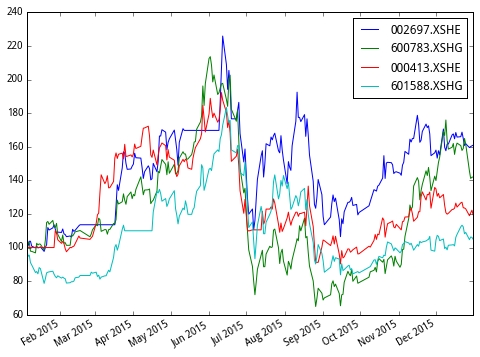

In [95]:
(data/data.ix[0]*100).plot(figsize = (8,6))

### **4.计算收益率**

用pandas计算收益率会比Numpy效率高一些，可以用shift方法

In [96]:
log_returns = np.log(data/data.shift(1))
log_returns.head()

,002697.XSHE,600783.XSHG,000413.XSHE,601588.XSHG
2015-01-05,NaN,NaN,NaN,NaN
2015-01-06,0.008316,0.032169,0,-0.054285
2015-01-07,0.028573,-0.002465,0,0.008230
2015-01-08,0.000000,-0.051739,0,-0.048278
2015-01-09,-0.028573,-0.001115,0,-0.015168


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd0420a5d90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fd041f03650>]], dtype=object)

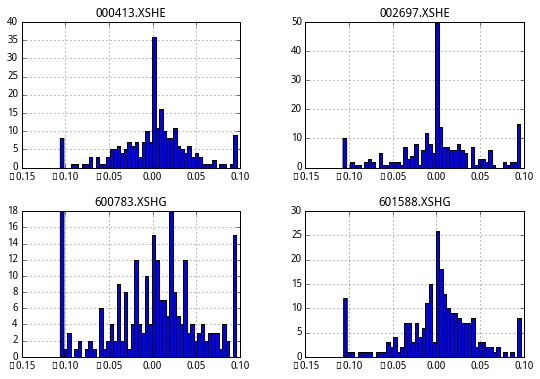

In [97]:
log_returns.hist(bins = 50, figsize = (9,6))

从以上结果看到4个数据集都和正态分布的要求相差太多。

### **5.输出每只股票的统计数据**

In [98]:
#定义print_statistics函数，为了更加易于理解的方式
#输出给定(历史或者模拟)数据集均值、偏斜度或者峰度等统计数字
def print_statistics(array):
    sta = scs.describe(array)
    print '%14s %15s' %('statistic','value')
    print 30*'-'
    print '%14s %15d' %('size', sta[0])
    print '%14s %15.5f' %('min', sta[1][0])
    print '%14s %15.5f' %('max', sta[1][1])
    print '%14s %15.5f' %('mean', sta[2])
    print '%14s %15.5f' %('std', np.sqrt(sta[3]))
    print '%14s %15.5f' %('skew', sta[4])
    print '%14s %15.5f' %('kurtosis', sta[5])

for st in stock:
    print '\nResults for stock %s' %st
    print 30*'-'
    log_data = np.array(log_returns[st].dropna())
    print_statistics(log_data)


Results for stock 002697.XSHE
------------------------------
     statistic           value
------------------------------
          size             243
           min        -0.10697
           max         0.09596
          mean         0.00196
           std         0.04652
          skew        -0.13239
      kurtosis         0.33900

Results for stock 600783.XSHG
------------------------------
     statistic           value
------------------------------
          size             243
           min        -0.10563
           max         0.09554
          mean         0.00144
           std         0.05250
          skew        -0.30149
      kurtosis        -0.30247

Results for stock 000413.XSHE
------------------------------
     statistic           value
------------------------------
          size             243
           min        -0.10569
           max         0.09651
          mean         0.00073
           std         0.04084
          skew        -0.20718
      ku

### **6.画qq图观察数据**

下面是002697.XSHE 对数收益率 分位数-分位数图

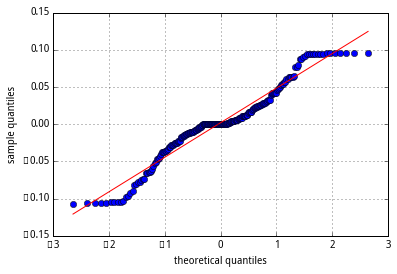

In [99]:
sm.qqplot(log_returns['002697.XSHE'].dropna(),line = 's')
plt.grid(True)
plt.xlabel('theoretical quantiles')
plt.ylabel('sample quantiles')

很显然，样本的分位数值不在一条直线上，表明“非正态性”。左侧和右侧分别有许多值远低于和远高于直线。这是典型的Fat tails。 Fat tails是频数分布中观察到的两端的异常值。

### **7.进行正态性检验**

In [100]:
def normality_test(array):
    '''
    对给定的数据集进行正态性检验
    组合了3中统计学测试
    偏度测试（Skewtest）——足够接近0
    峰度测试（Kurtosistest)——足够接近0
    正态性测试
    '''
    print 'Skew of data set %15.3f' % scs.skew(array)
    print 'Skew test p-value %14.3f' % scs.skewtest(array)[1]
    print 'Kurt of data set %15.3f' % scs.kurtosis(array)
    print 'Kurt test p-value %14.3f' % scs.kurtosistest(array)[1]
    print 'Norm test p-value %14.3f' % scs.normaltest(array)[1]

for st in stock:
    print '\nResults for st %s' %st
    print 32*'-'
    log_data = np.array(log_returns[st].dropna())
    normality_test(log_data)


Results for st 002697.XSHE
--------------------------------
Skew of data set          -0.132
Skew test p-value          0.388
Kurt of data set           0.339
Kurt test p-value          0.233
Norm test p-value          0.338

Results for st 600783.XSHG
--------------------------------
Skew of data set          -0.301
Skew test p-value          0.053
Kurt of data set          -0.302
Kurt test p-value          0.346
Norm test p-value          0.099

Results for st 000413.XSHE
--------------------------------
Skew of data set          -0.207
Skew test p-value          0.179
Kurt of data set           0.781
Kurt test p-value          0.032
Norm test p-value          0.041

Results for st 601588.XSHG
--------------------------------
Skew of data set          -0.465
Skew test p-value          0.004
Kurt of data set           0.809
Kurt test p-value          0.028
Norm test p-value          0.001


从上述测试的p值来看，否定了数据集呈正态分布的测试假设。
这说明，**股票市场收益率的正态假设不成立**。

---

## PART TWO：均值-方差投资组合理论

该理论基于用均值和方差来表述组合的优劣的前提。将选取几只股票，用蒙特卡洛模拟初步探究组合的有效前沿。

通过最大Sharpe和最小方差两种优化来找到最优的资产组合配置权重参数。

最后，刻画出可能的分布，两种最优以及组合的有效前沿。

### **1.选取几只感兴趣的股票**

000413 东旭光电，000063 中兴通讯，002007 华兰生物，000001 平安银行，000002 万科A

并比较一下数据（2015-01-01至2015-12-31）

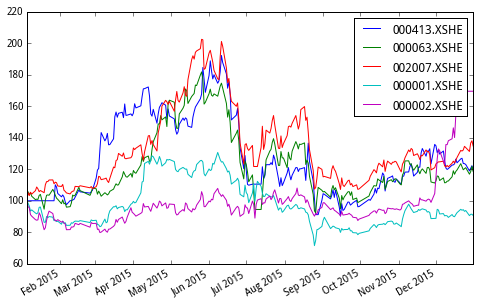

In [102]:
stock_set = ['000413.XSHE','000063.XSHE','002007.XSHE','000001.XSHE','000002.XSHE']
noa = len(stock_set)
df = get_price(stock_set, start_date, end_date, 'daily', ['close'])
data = df['close']
#规范化后时序数据
(data/data.ix[0]*100).plot(figsize = (8,5))

# chen

/home/nocater/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


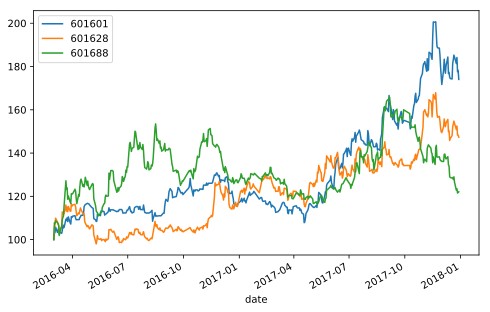

In [31]:
stock_set = [601601, 601628, 601688]
# stock_set = stocks
noa = len(stock_set)
data = df[stock_set]
data = data['2016-3-1':'2017-12-31']
#规范化后时序数据
(data/data.ix[0]*100).plot(figsize = (8,5))

### **2.计算不同证券的均值、协方差**

每年252个交易日，用每日收益得到年化收益。

计算投资资产的协方差是构建资产组合过程的核心部分。运用pandas内置方法生产协方差矩阵。

In [32]:
returns = np.log(data / data.shift(1))
returns.mean()*252

601601    0.309596
601628    0.216464
601688    0.111407
dtype: float64

In [33]:
returns.cov()*252

,601601,601628,601688
601601,0.056226,0.039077,0.024193
601628,0.039077,0.066134,0.033313
601688,0.024193,0.033313,0.090411


### **3.给不同资产随机分配初始权重**

由于A股不允许建立空头头寸，所有的权重系数均在0-1之间

In [34]:
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([0.12619092, 0.43653892, 0.43727017])

### **4.计算预期组合年化收益、组合方差和组合标准差**

In [35]:
np.sum(returns.mean()*weights)*252

0.18227850161425307

In [36]:
np.dot(weights.T, np.dot(returns.cov()*252,weights))

0.05047843342799925

In [37]:
np.sqrt(np.dot(weights.T, np.dot(returns.cov()* 252,weights)))

0.22467406042531757

### **5.用蒙特卡洛模拟产生大量随机组合**

进行到此，我们最想知道的是给定的一个股票池（证券组合）如何找到风险和收益平衡的位置。

下面通过一次蒙特卡洛模拟，产生大量随机的权重向量，并记录随机组合的预期收益和方差。

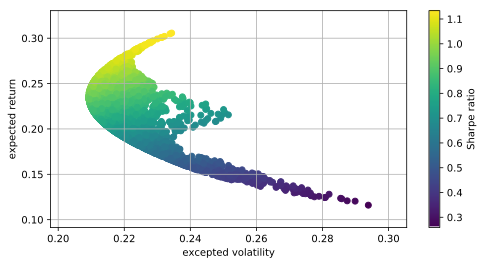

In [38]:
port_returns = []
port_variance = []
for p in range(4000):
    weights = np.random.random(noa)
    weights /=np.sum(weights)
    port_returns.append(np.sum(returns.mean()*252*weights))
    port_variance.append(np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights))))

port_returns = np.array(port_returns)
port_variance = np.array(port_variance)

#无风险利率设定为4%
risk_free = 0.04
plt.figure(figsize = (8,4))
plt.scatter(port_variance, port_returns, c=(port_returns-risk_free)/port_variance, marker = 'o')
plt.grid(True)
plt.xlabel('excepted volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')

### **6.投资组合优化1——sharpe最大**

建立statistics函数来记录重要的投资组合统计数据（收益，方差和夏普比）

通过对约束最优问题的求解，得到最优解。其中约束是权重总和为1。

In [39]:
def statistics(weights):
    weights = np.array(weights)
    port_returns = np.sum(returns.mean()*weights)*252
    port_variance = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252,weights)))
    return np.array([port_returns, port_variance, port_returns/port_variance])

#最优化投资组合的推导是一个约束最优化问题
import scipy.optimize as sco

#最小化夏普指数的负值
def min_sharpe(weights):
    return -statistics(weights)[2]

#约束是所有参数(权重)的总和为1。这可以用minimize函数的约定表达如下
cons = ({'type':'eq', 'fun':lambda x: np.sum(x)-1})

#我们还将参数值(权重)限制在0和1之间。这些值以多个元组组成的一个元组形式提供给最小化函数
bnds = tuple((0,1) for x in range(noa))

#优化函数调用中忽略的唯一输入是起始参数列表(对权重的初始猜测)。我们简单的使用平均分布。
opts = sco.minimize(min_sharpe, noa*[1./noa,], method = 'SLSQP', bounds = bnds, constraints = cons)
opts

     fun: -1.3056631551247744
     jac: array([-1.32620335e-06,  2.08765268e-04,  9.45406854e-02])
 message: 'Optimization terminated successfully.'
    nfev: 25
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([9.93746388e-01, 6.25361219e-03, 3.03576608e-18])

得到的最优组合**权重向量**为：

In [40]:
opts['x'].round(3)

array([0.994, 0.006, 0.   ])

sharpe最大的组合3个**统计数据**分别为：

In [41]:
#预期收益率、预期波动率、最优夏普指数
statistics(opts['x']).round(3)

array([0.309, 0.237, 1.306])

### **7.投资组合优化2——方差最小**

接下来，我们通过方差最小来选出最优投资组合。

In [42]:
#但是我们定义一个函数对 方差进行最小化
def min_variance(weights):
    return statistics(weights)[1]

optv = sco.minimize(min_variance, noa*[1./noa,],method = 'SLSQP', bounds = bnds, constraints = cons)
optv

     fun: 0.2092855042756618
     jac: array([0.20928668, 0.20928117, 0.20928705])
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.50484114, 0.23084393, 0.26431492])

方差最小的最优组合**权重向量**及**组合的统计数据**分别为：

In [43]:
optv['x'].round(3)

array([0.505, 0.231, 0.264])

In [44]:
#得到的预期收益率、波动率和夏普指数
statistics(optv['x']).round(3)

array([0.236, 0.209, 1.126])

### **8.组合的有效前沿**

有效前沿有既定的目标收益率下方差最小的投资组合构成。

在最优化时采用两个约束，1.给定目标收益率，2.投资组合权重和为1。

In [45]:
def min_variance(weights):
    return statistics(weights)[1]

#在不同目标收益率水平（target_returns）循环时，最小化的一个约束条件会变化。
target_returns = np.linspace(0.0,0.5,50)
target_variance = []
for tar in target_returns:
    cons = ({'type':'eq','fun':lambda x:statistics(x)[0]-tar},{'type':'eq','fun':lambda x:np.sum(x)-1})
    res = sco.minimize(min_variance, noa*[1./noa,],method = 'SLSQP', bounds = bnds, constraints = cons)
    target_variance.append(res['fun'])

target_variance = np.array(target_variance)

下面是最优化结果的展示。

**叉号**：构成的曲线是有效前沿（目标收益率下最优的投资组合）

**红星**：sharpe最大的投资组合

**黄星**：方差最小的投资组合

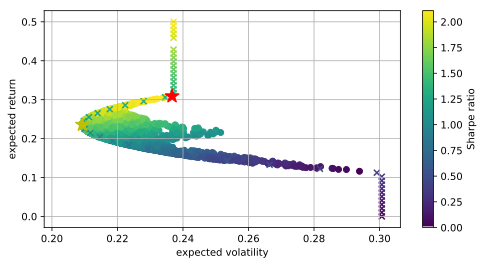

In [46]:
plt.figure(figsize = (8,4))
#圆圈：蒙特卡洛随机产生的组合分布
plt.scatter(port_variance, port_returns, c = port_returns/port_variance,marker = 'o')
#叉号：有效前沿
plt.scatter(target_variance,target_returns, c = target_returns/target_variance, marker = 'x')
#红星：标记最高sharpe组合
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0], 'r*', markersize = 15.0)
#黄星：标记最小方差组合
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize = 15.0)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')